<a href="https://colab.research.google.com/github/alfafimel/PREDICTION-OF-CAB-PRICES-UBER-LYFT-/blob/main/Group5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Analysis of Cab Rides Data**
---



**Problem Statement**

Uber and Lyft's ride prices are not constant like public transport. They are greatly affected by the demand and supply of rides at a given time. We would like to understand what drives the demand of the rides and how the prices vary with time and weather conditions. Different times and weather types could have surges on the number of rides being requested.



**Objectives** 

* To understand the factors that influence the price of a cab

* To predict trip prices based on these factors 





**Defining the Metrics for Success**

Our project will be deemed successful when we understand the factors influencing cab prices and creating predictive models and their performance evaluated

**Recording the Experimental Design**


1. Problem Definition
2. Data Sourcing
3. Checking the Data
4. Performing Data Cleaning
5. Performing Exploratory Data Analysis
6. Data Modelling

**Loading the required libraries**

In [ ]:
# install.packages("reshape2")
# install.packages("psych")
# install.packages("corrplot")
# install.packages("car")
# install.packages("e1071")

In [ ]:
# Loading libraries
library(readr)
library(tidyr)
library(stringr)
library(dplyr)
library(ggplot2)
library(lubridate)
library(reshape2)
library(psych)
library(RColorBrewer)
library(corrplot)
library(e1071)
library(caret)
library(glmnet)

**Reading in the data**

In [ ]:
# Reading in the data
rides <- read_csv("cab_rides.csv");
weather <- read_csv("weather.csv");

**Checking the data**

In [ ]:
# Determining the number of records
print(dim(rides))
print(dim(weather))

[1] 114568     10
[1] 6276    8


In [ ]:
# Viewing the top of our rides dataset
head(rides)

distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.44,Lyft,1.544953e+12,North Station,Haymarket Square,5.0,1,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
0.44,Lyft,1.543284e+12,North Station,Haymarket Square,11.0,1,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
0.44,Lyft,1.543367e+12,North Station,Haymarket Square,7.0,1,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
0.44,Lyft,1.543554e+12,North Station,Haymarket Square,26.0,1,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
0.44,Lyft,1.543463e+12,North Station,Haymarket Square,9.0,1,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL
0.44,Lyft,1.545071e+12,North Station,Haymarket Square,16.5,1,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,lyft_lux,Lux Black


In [ ]:
# Viewing the bottom of our weather dataset
head(weather)

temp,location,clouds,pressure,rain,time_stamp,humidity,wind
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
42.42,Back Bay,1,1012.14,0.1228,1545003901,0.77,11.25
42.43,Beacon Hill,1,1012.15,0.1846,1545003901,0.76,11.32
42.50,Boston University,1,1012.15,0.1089,1545003901,0.76,11.07
42.11,Fenway,1,1012.13,0.0969,1545003901,0.77,11.09
43.13,Financial District,1,1012.14,0.1786,1545003901,0.75,11.49
42.34,Haymarket Square,1,1012.15,0.2068,1545003901,0.77,11.49


In [ ]:
# Checking the datatypes
print('Weather data columns:' )
sapply(weather, class)

print('Cab rides data: ')
sapply(rides, class)

[1] "Weather data columns:"


temp    location      clouds    pressure        rain  time_stamp 
  "numeric" "character"   "numeric"   "numeric"   "numeric"   "numeric" 
   humidity        wind 
  "numeric"   "numeric"

[1] "Cab rides data: "


distance         cab_type       time_stamp      destination 
       "numeric"      "character"        "numeric"      "character" 
          source            price surge_multiplier               id 
     "character"        "numeric"        "numeric"      "character" 
      product_id             name 
     "character"      "character"

In [ ]:
# Converting timestamp to datetime object
weather$time_stamp <- as_datetime(weather$time_stamp)
rides$time_stamp <- rides$time_stamp/1000
rides$time_stamp <- as_datetime(rides$time_stamp)

In [ ]:
# Checking for duplicates
duplicated_weather <- weather[duplicated(weather),]
duplicated_weather

duplicated_rides <- rides[duplicated(rides),]
duplicated_rides

temp,location,clouds,pressure,rain,time_stamp,humidity,wind
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>


distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
<dbl>,<chr>,<dttm>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>


No duplicates

In [ ]:
# Checking for missing values
print('Cab ride data: ' )
round(colSums(is.na(rides))/ dim(rides)[1] * 100, 1)

print('Weather data: ' )
round(colSums(is.na(weather))/ dim(weather)[1] * 100, 1)

[1] "Cab ride data: "


distance         cab_type       time_stamp      destination 
             0.0              0.0              0.0              0.0 
          source            price surge_multiplier               id 
             0.0              7.9              0.0              0.0 
      product_id             name 
             0.0              0.0

[1] "Weather data: "


temp   location     clouds   pressure       rain time_stamp   humidity 
       0.0        0.0        0.0        0.0       85.8        0.0        0.0 
      wind 
       0.0

Price column in cab rides data has 7.8% missing values while rain column in weather data has 85% missing values.

In [ ]:
# Drop rows with missing values
clean_rides <- na.omit(rides)

# Drop id column
clean_rides$id <- NULL

# Create date and hour column for easier merging
clean_rides <- clean_rides %>% mutate(date = lubridate::date(time_stamp), hour = lubridate::hour(time_stamp))

dim(clean_rides)


[1] 637976     11

In [ ]:
clean_weather <- weather

# Drop rain column due to high number of missing values
clean_weather$rain <- NULL

# Create date and hour column for easier merging
clean_weather <- clean_weather %>% 
mutate(date = lubridate::date(time_stamp), hour = lubridate::hour(time_stamp))

# Rename location column to source for merging
clean_weather <- clean_weather %>% rename(source = location)

head(clean_weather)

temp,source,clouds,pressure,time_stamp,humidity,wind,date,hour
<dbl>,<chr>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<date>,<int>
42.42,Back Bay,1,1012.14,2018-12-16 23:45:01,0.77,11.25,2018-12-16,23
42.43,Beacon Hill,1,1012.15,2018-12-16 23:45:01,0.76,11.32,2018-12-16,23
42.50,Boston University,1,1012.15,2018-12-16 23:45:01,0.76,11.07,2018-12-16,23
42.11,Fenway,1,1012.13,2018-12-16 23:45:01,0.77,11.09,2018-12-16,23
43.13,Financial District,1,1012.14,2018-12-16 23:45:01,0.75,11.49,2018-12-16,23
42.34,Haymarket Square,1,1012.15,2018-12-16 23:45:01,0.77,11.49,2018-12-16,23


In [ ]:
# Average weather readings per hour and location
clean_weather <- clean_weather %>% 
select(temp, source, clouds, pressure, humidity, wind, date, hour) %>% 
group_by(source, date, hour) %>% 
summarise_all(mean)

head(clean_weather)

source,date,hour,temp,clouds,pressure,humidity,wind
<chr>,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Back Bay,2018-11-26,3,41.04000,0.8700000,1014.390,0.9200000,1.460000
Back Bay,2018-11-26,4,40.65800,0.8940000,1014.008,0.9260000,2.646000
Back Bay,2018-11-26,5,40.56125,0.9300000,1013.821,0.9212500,2.496250
Back Bay,2018-11-26,6,40.62733,0.9906667,1014.197,0.9133333,1.350667
Back Bay,2018-11-26,7,41.13750,0.9700000,1014.293,0.9200000,1.735000
Back Bay,2018-11-26,8,40.92000,0.9800000,1014.483,0.9233333,1.330000


In [ ]:
# Merge the two dataframes
ride_data <- left_join(clean_rides, clean_weather, by = c("source", "date", "hour"))
head(ride_data)

distance,cab_type,time_stamp,destination,source,price,surge_multiplier,product_id,name,date,hour,temp,clouds,pressure,humidity,wind
<dbl>,<chr>,<dttm>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.44,Lyft,2018-12-16 09:30:07,North Station,Haymarket Square,5.0,1,lyft_line,Shared,2018-12-16,9,38.460,0.2900000,1022.25,0.7600000,7.68
0.44,Lyft,2018-11-27 02:00:23,North Station,Haymarket Square,11.0,1,lyft_premier,Lux,2018-11-27,2,44.065,0.9950000,1002.88,0.8950000,12.63
0.44,Lyft,2018-11-28 01:00:22,North Station,Haymarket Square,7.0,1,lyft,Lyft,2018-11-28,1,NA,NA,NA,NA,NA
0.44,Lyft,2018-11-30 04:53:02,North Station,Haymarket Square,26.0,1,lyft_luxsuv,Lux Black XL,2018-11-30,4,35.080,0.0000000,1013.71,0.7000000,5.25
0.44,Lyft,2018-11-29 03:49:20,North Station,Haymarket Square,9.0,1,lyft_plus,Lyft XL,2018-11-29,3,37.680,0.4333333,998.42,0.7066667,11.16
0.44,Lyft,2018-12-17 18:25:12,North Station,Haymarket Square,16.5,1,lyft_lux,Lux Black,2018-12-17,18,40.780,0.9300000,1000.15,0.7900000,7.55


In [ ]:
# Drop rows with null weather data
ride_data <- na.omit(ride_data)
dim(ride_data)

[1] 635242     16

In [ ]:
# Summary of ride data
glimpse(ride_data)

Rows: 635,242
Columns: 16
$ distance         <dbl> 0.44, 0.44, 0.44, 0.44, 0.44, 1.08, 1.08, 1.08, 1.08…
$ cab_type         <chr> "Lyft", "Lyft", "Lyft", "Lyft", "Lyft", "Lyft", "Lyf…
$ time_stamp       <dttm> 2018-12-16 09:30:07, 2018-11-27 02:00:23, 2018-11-3…
$ destination      <chr> "North Station", "North Station", "North Station", "…
$ source           <chr> "Haymarket Square", "Haymarket Square", "Haymarket S…
$ price            <dbl> 5.0, 11.0, 26.0, 9.0, 16.5, 10.5, 16.5, 3.0, 27.5, 1…
$ surge_multiplier <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ product_id       <chr> "lyft_line", "lyft_premier", "lyft_luxsuv", "lyft_pl…
$ name             <chr> "Shared", "Lux", "Lux Black XL", "Lyft XL", "Lux Bla…
$ date             <date> 2018-12-16, 2018-11-27, 2018-11-30, 2018-11-29, 201…
$ hour             <int> 9, 2, 4, 3, 18, 5, 19, 6, 10, 16, 19, 22, 10, 19, 23…
$ temp             <dbl> 38.46000, 44.06500, 35.08000, 37.68000, 40.78000, 40…
$ clouds           <dbl> 0

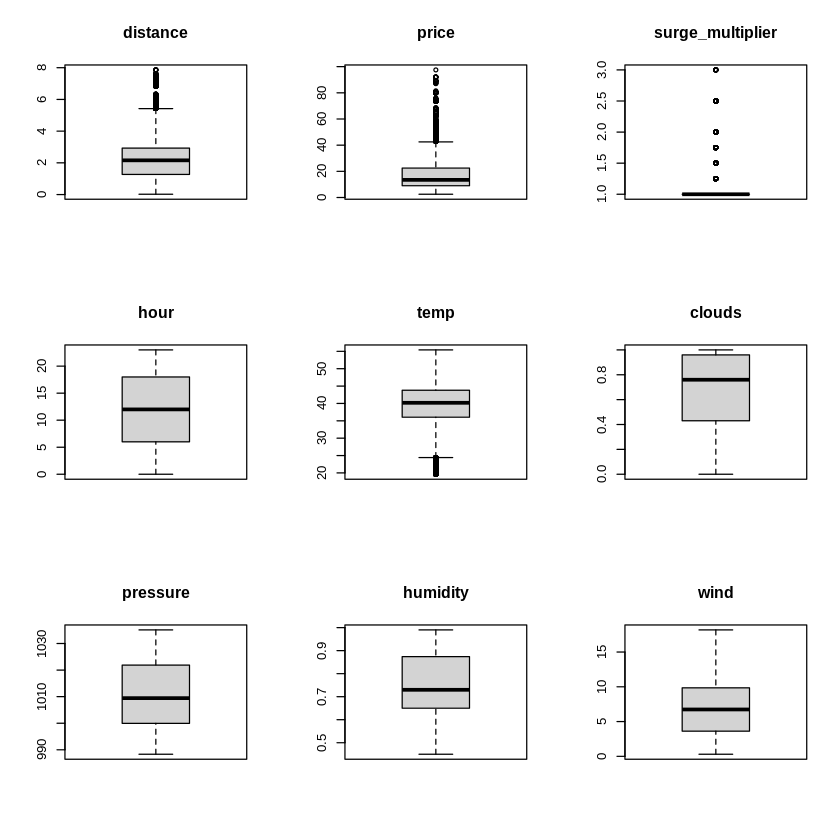

In [ ]:
# Checking for outliers
numeric_col <- ride_data %>% select_if(is.numeric)

# Boxplot of numeric columns
par (mfrow= c ( 3, 3))
for (i in 1 : length (numeric_col)) {
boxplot (numeric_col[,i], main= names (numeric_col[i]), type= "l" )
}

Outliers detected in distance, price and temp columns.

**Exploratory Data Analysis**

In [ ]:
# Description of the numeric columns in rides data
describe(numeric_col)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
distance,1,635242,2.1888757,1.13532615,2.16,2.1066237,1.215732,0.020,7.86,7.840,0.81735344,1.1523613,0.0014244626
price,2,635242,16.5440832,9.32337248,13.50,15.5112030,8.895600,2.500,97.50,95.000,1.04561323,1.2241155,0.0116977796
surge_multiplier,3,635242,1.0150643,0.09541268,1.00,1.0000000,0.000000,1.000,3.00,2.000,7.97187430,73.8666956,0.0001197117
hour,4,635242,11.6364488,6.94576477,12.00,11.6696321,8.895600,0.000,23.00,23.000,-0.04958729,-1.1783981,0.0087146604
temp,5,635242,39.2053747,6.60487202,40.18,39.6004480,5.537511,19.620,55.41,35.790,-0.60984578,0.5650342,0.0082869516
clouds,6,635242,0.6698418,0.31239315,0.76,0.7026096,0.340998,0.000,1.00,1.000,-0.61552418,-0.9234170,0.0003919511
pressure,7,635242,1010.2335566,13.37541574,1009.45,1009.8003916,16.664424,988.325,1035.12,46.795,0.14852952,-1.0944020,0.0167817670
humidity,8,635242,0.7482741,0.12890108,0.73,0.7514928,0.148260,0.450,0.99,0.540,-0.07598114,-0.9892072,0.0001617286
wind,9,635242,6.9380098,3.64510317,6.74,6.8075437,4.625712,0.300,18.18,17.880,0.27936800,-0.6839982,0.0045734109


Distance, price and surge multiplier columns are positively skewed.

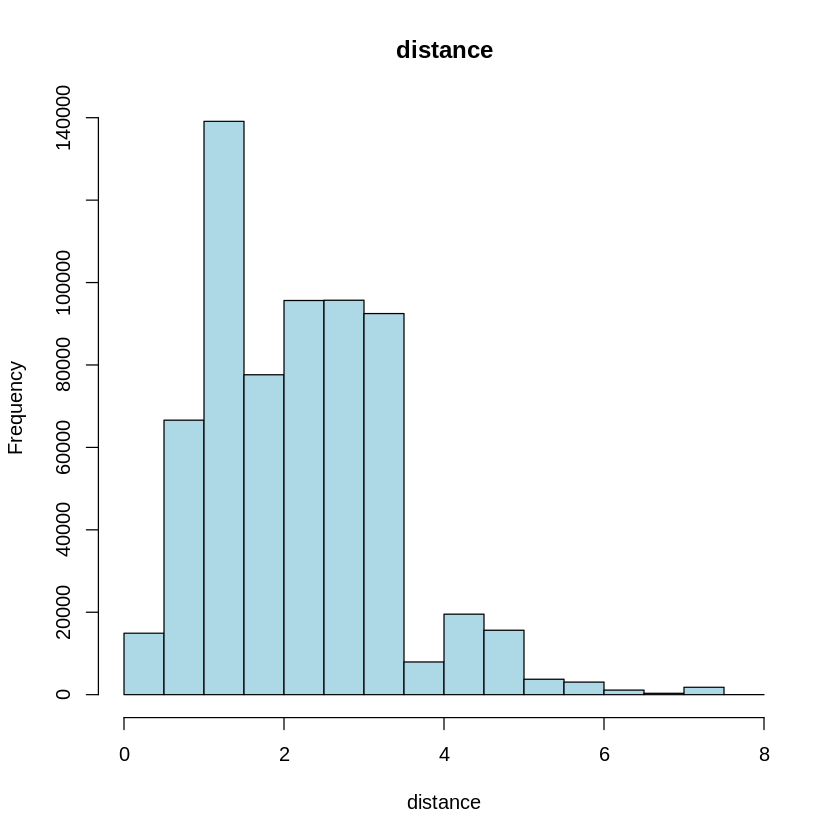

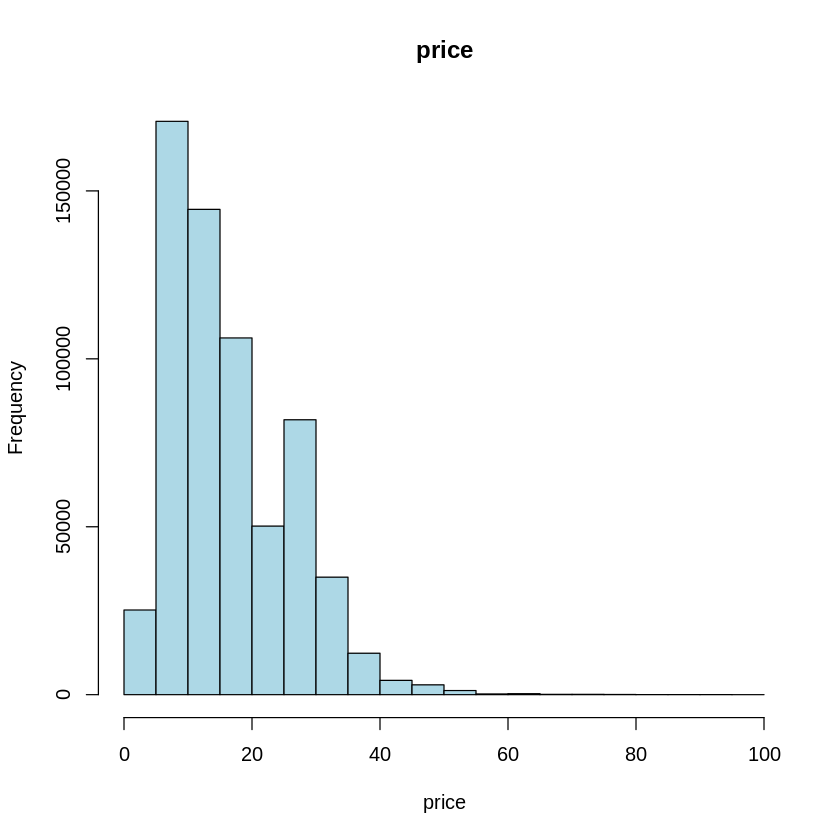

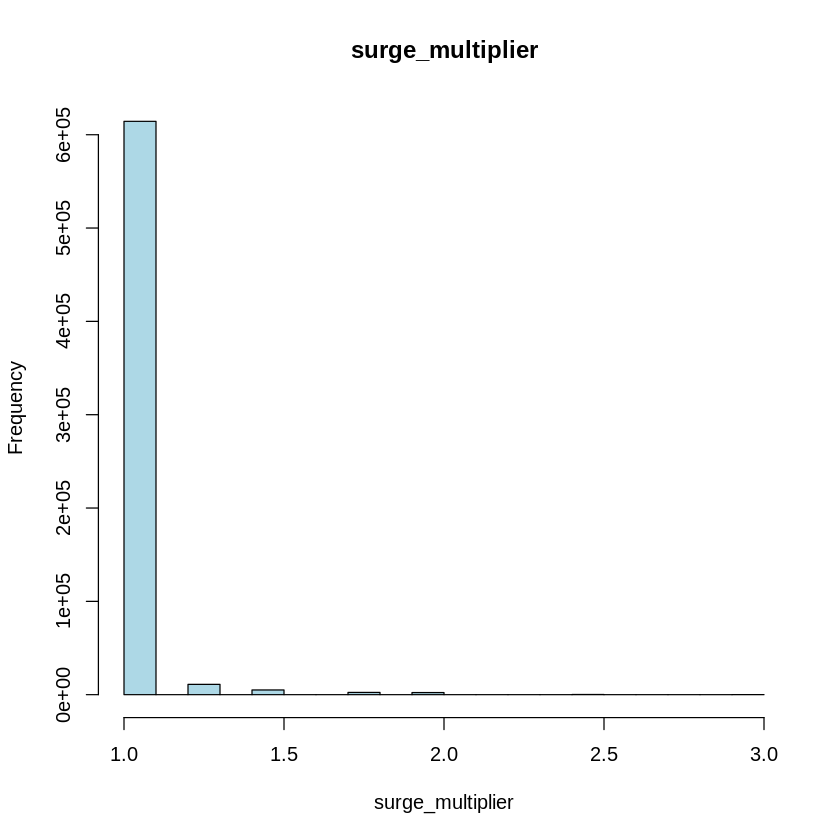

In [ ]:
# Histograms for skewed columns
numeric_col <- as.data.frame(sapply(numeric_col, as.numeric))
for (col in 1:ncol(numeric_col[, 1:3])){
  hist(numeric_col[,col], main = names(numeric_col[col]), col = 'lightblue', xlab = names(numeric_col[col]))
}

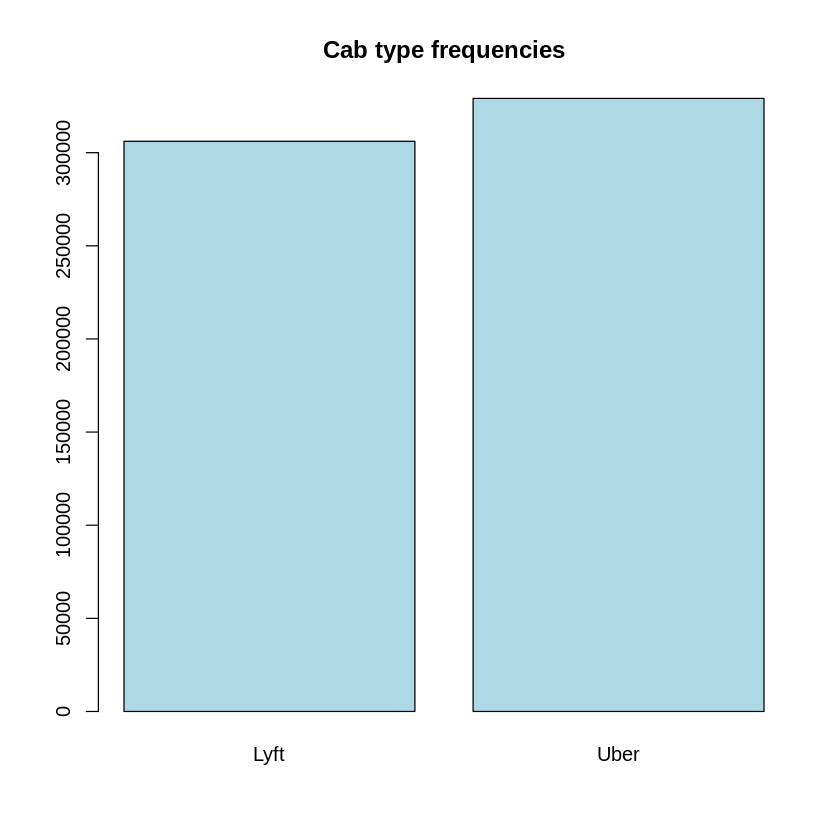

In [ ]:
# Types of rides
barplot(table(ride_data$cab_type), main = 'Cab type frequencies', col='lightblue')

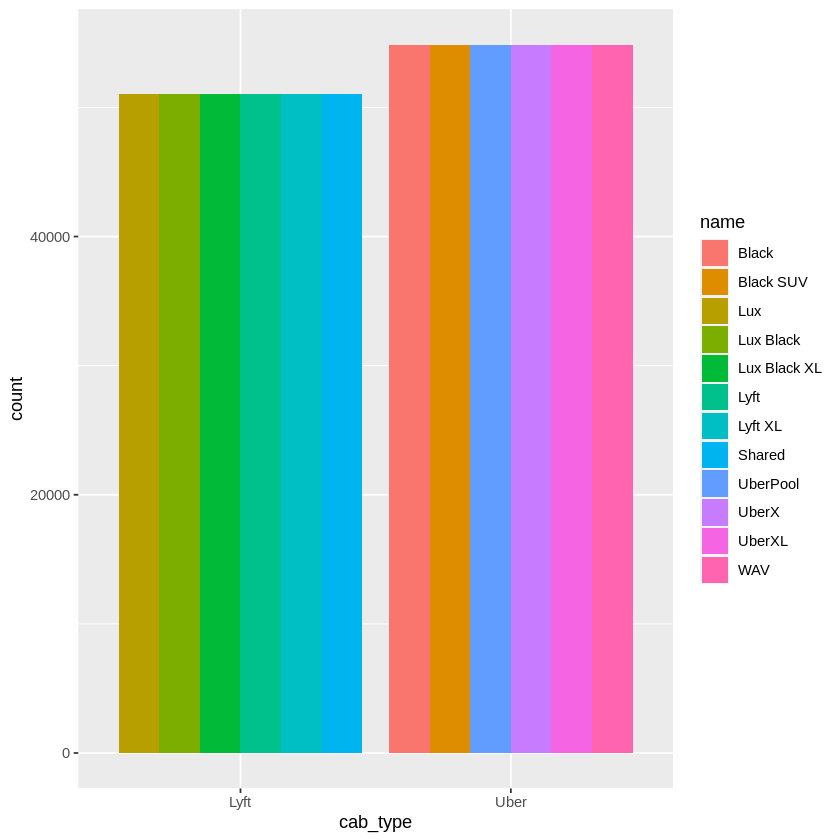

In [ ]:
# Distribution of cab names per cab type
ggplot(data=ride_data) +
geom_bar(mapping = aes(x = cab_type, fill = name), position = "dodge")

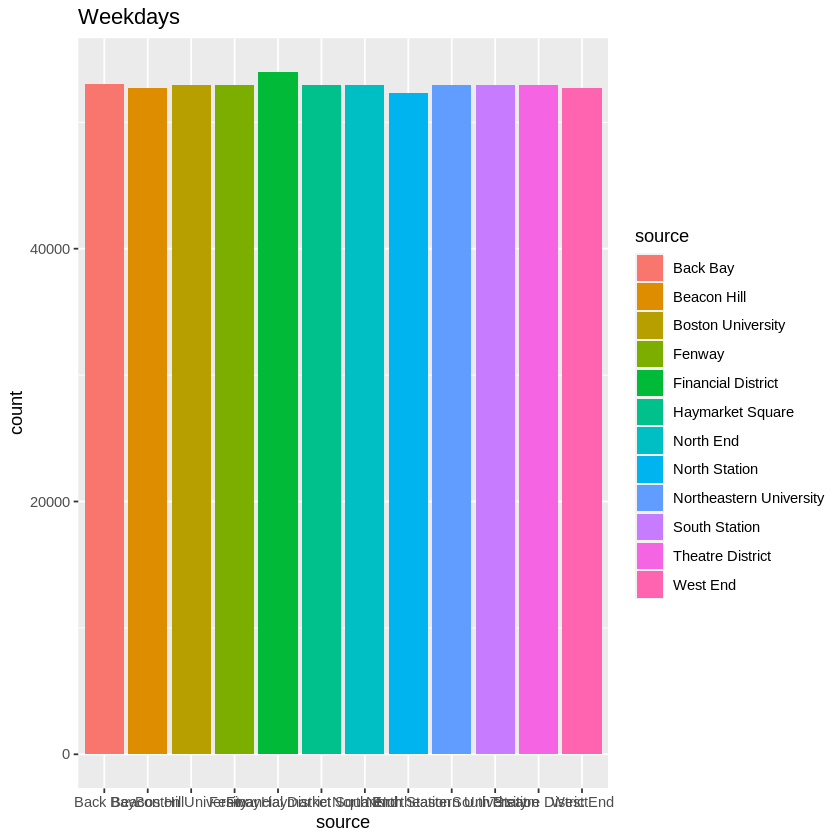

In [ ]:
# Popular source
ggplot(data=ride_data, aes(x=source, fill=source)) +
  ggtitle("Weekdays") +
  geom_bar()

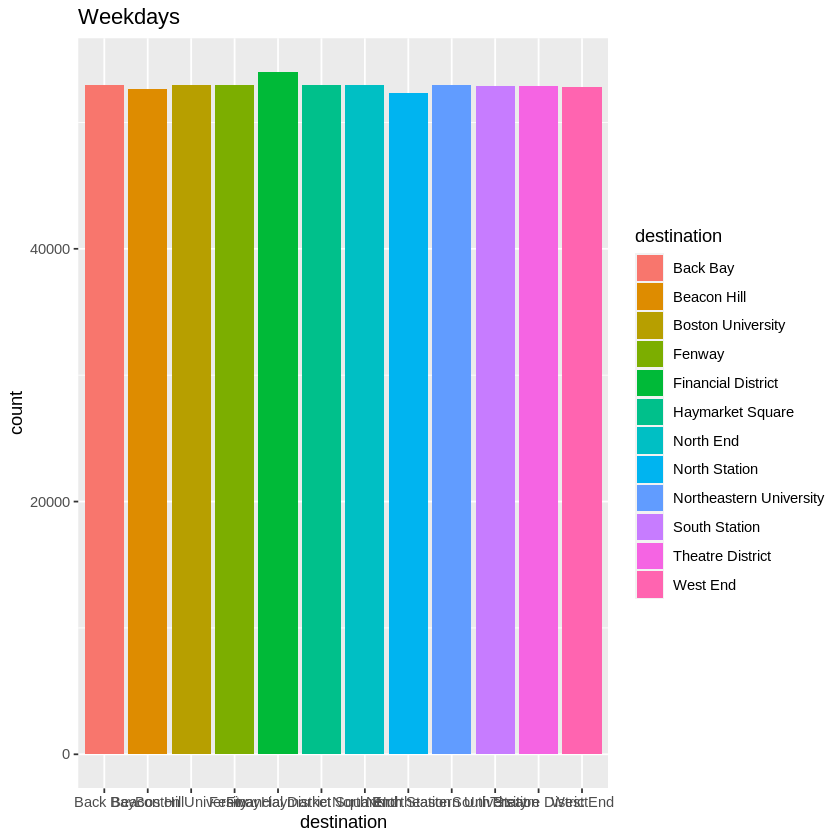

In [ ]:
# Popular destination
ggplot(data=ride_data, aes(x=destination, fill=destination)) +
  ggtitle("Weekdays") +
  geom_bar()

In [ ]:
# Which cabs have higher average prices?
ride_data %>%
select(cab_type, price) %>%
group_by(cab_type) %>%
summarise(mean=mean(price)) %>%
arrange(desc(mean))

`summarise()` ungrouping output (override with `.groups` argument)



cab_type,mean
<chr>,<dbl>
Lyft,17.35078
Uber,15.79385


In [ ]:
# Which cabs had the highest average prices
ride_data %>%
select(cab_type, price, name) %>%
group_by(name, cab_type) %>%
summarise(mean=mean(price)) %>%
arrange(desc(mean))

`summarise()` regrouping output by 'name' (override with `.groups` argument)



name,cab_type,mean
<chr>,<chr>,<dbl>
Lux Black XL,Lyft,32.321567
Black SUV,Uber,30.286003
Lux Black,Lyft,23.060466
Black,Uber,20.520902
Lux,Lyft,17.769546
UberXL,Uber,15.677541
Lyft XL,Lyft,15.308207
UberX,Uber,9.764805
WAV,Uber,9.764318


In [ ]:
# Most expensive hour for uber
ride_data[ride_data$cab_type == "Uber", ] %>%
group_by(hour, cab_type) %>%
summarise(mean=mean(price)) %>%
arrange(desc(mean))

`summarise()` regrouping output by 'hour' (override with `.groups` argument)



hour,cab_type,mean
<int>,<chr>,<dbl>
21,Uber,15.90787
20,Uber,15.88198
8,Uber,15.86805
2,Uber,15.86675
17,Uber,15.86078
4,Uber,15.85671
18,Uber,15.85310
6,Uber,15.82575
14,Uber,15.81234


In [ ]:
# Most expensive hour for Lyft
ride_data[ride_data$cab_type == "Lyft", ] %>%
group_by(hour, cab_type) %>%
summarise(mean=mean(price)) %>%
arrange(desc(mean))

`summarise()` regrouping output by 'hour' (override with `.groups` argument)



hour,cab_type,mean
<int>,<chr>,<dbl>
11,Lyft,17.50034
0,Lyft,17.45006
22,Lyft,17.44425
8,Lyft,17.40299
19,Lyft,17.39036
20,Lyft,17.38929
17,Lyft,17.37512
4,Lyft,17.36670
14,Lyft,17.36303


In [ ]:
# Average weather readings per hour and location
clean_weather <- clean_weather %>% 
select(temp, source, clouds, pressure, humidity, wind, date, hour) %>% 
group_by(source, date, hour) %>% 
summarise_all(mean)

head(clean_weather)

source,date,hour,temp,clouds,pressure,humidity,wind
<chr>,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Back Bay,2018-11-26,3,41.04000,0.8700000,1014.390,0.9200000,1.460000
Back Bay,2018-11-26,4,40.65800,0.8940000,1014.008,0.9260000,2.646000
Back Bay,2018-11-26,5,40.56125,0.9300000,1013.821,0.9212500,2.496250
Back Bay,2018-11-26,6,40.62733,0.9906667,1014.197,0.9133333,1.350667
Back Bay,2018-11-26,7,41.13750,0.9700000,1014.293,0.9200000,1.735000
Back Bay,2018-11-26,8,40.92000,0.9800000,1014.483,0.9233333,1.330000


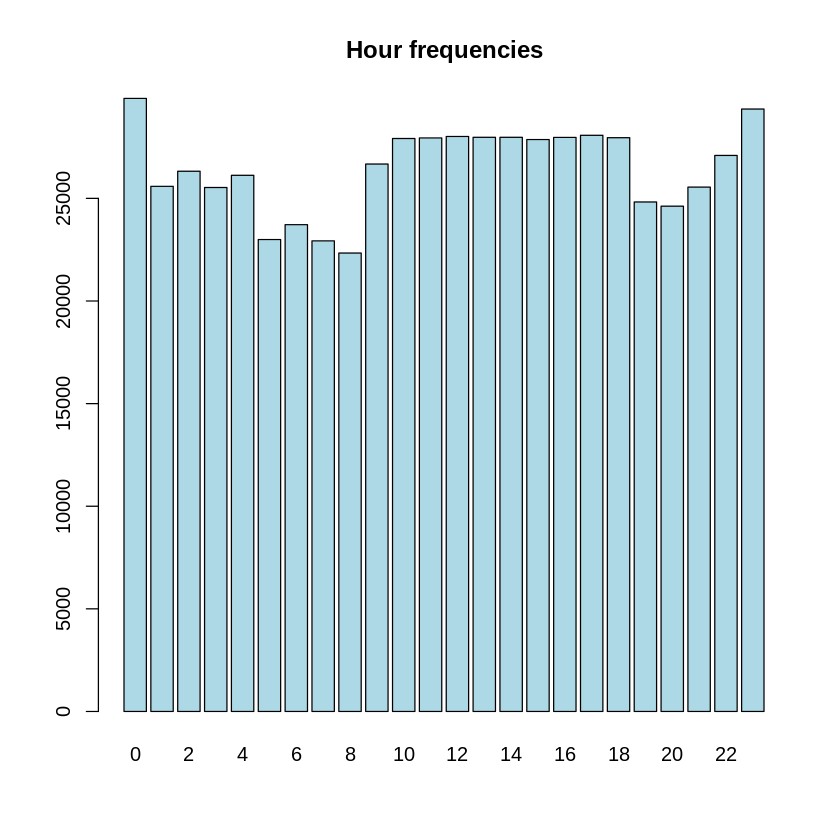

In [ ]:
# Popular hour for ride requests
barplot(table(ride_data$hour), main = 'Hour frequencies', col='lightblue')


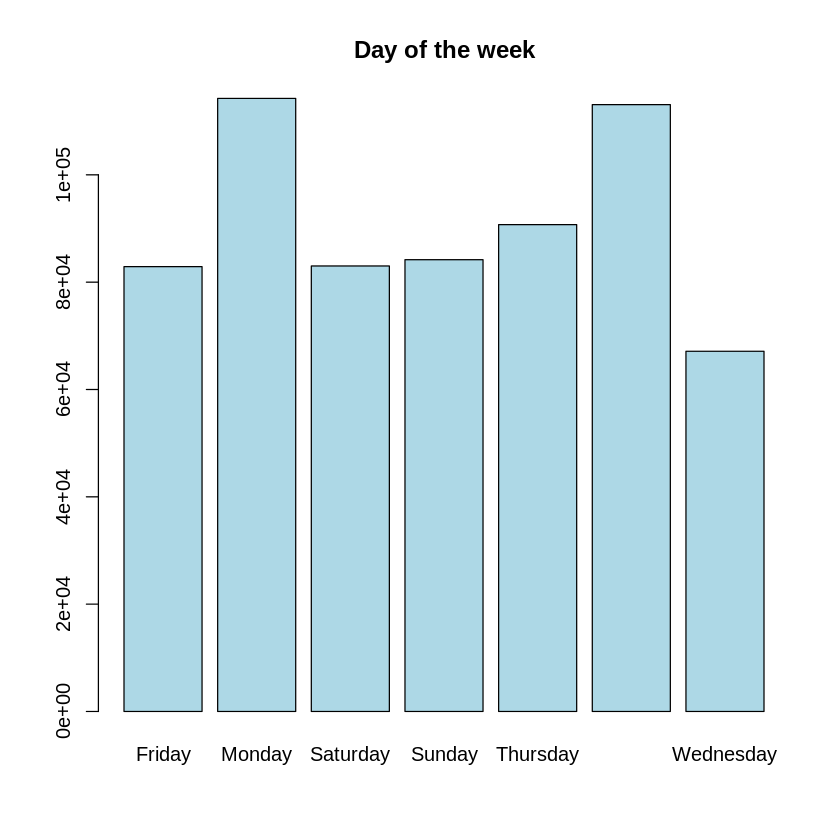

In [ ]:
# Number of requests for weekdays 
ride_data$weekday <- weekdays(ride_data$time_stamp)
barplot(table(ride_data$weekday), main = 'Day of the week', col='lightblue')


In [ ]:
# Most expensive weekday for Lyft
ride_data[ride_data$cab_type == "Lyft", ] %>%
group_by(weekday, cab_type) %>%
summarise(mean=mean(price)) %>%
arrange(desc(mean))

`summarise()` regrouping output by 'weekday' (override with `.groups` argument)



weekday,cab_type,mean
<chr>,<chr>,<dbl>
Thursday,Lyft,17.41277
Saturday,Lyft,17.39077
Sunday,Lyft,17.37943
Tuesday,Lyft,17.34813
Friday,Lyft,17.33898
Wednesday,Lyft,17.32359
Monday,Lyft,17.27859


In [ ]:
# Most expensive weekday for Uber
ride_data[ride_data$cab_type == "Uber", ] %>%
group_by(weekday, cab_type) %>%
summarise(mean=mean(price)) %>%
arrange(desc(mean))

`summarise()` regrouping output by 'weekday' (override with `.groups` argument)



weekday,cab_type,mean
<chr>,<chr>,<dbl>
Tuesday,Uber,15.88489
Sunday,Uber,15.82133
Thursday,Uber,15.80298
Saturday,Uber,15.79284
Wednesday,Uber,15.76602
Monday,Uber,15.76562
Friday,Uber,15.69376


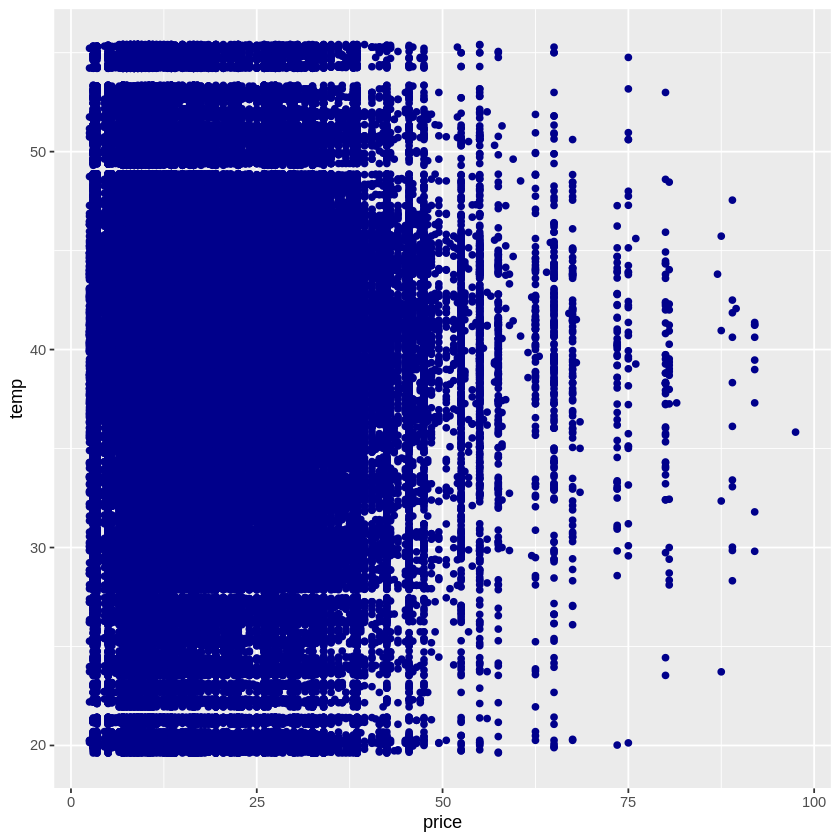

In [ ]:
# Variation of temperature and price
ride_data[order(ride_data$time_stamp),] %>%
  ggplot(aes(x=price, y=temp)) +
  geom_point(colour="darkblue") 

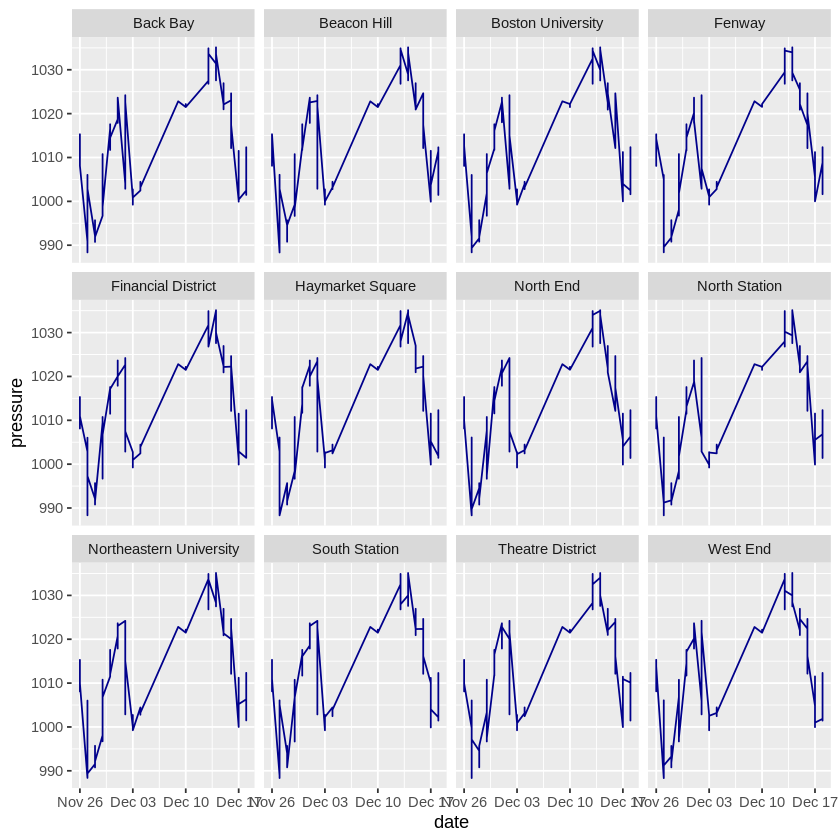

In [ ]:
# Pressure plot over time in different locations
ride_data %>%
  ggplot(aes(x=date, y=pressure)) +
  geom_line(colour="darkblue") +
  facet_wrap(~source)

In [ ]:
# Prices variation by source location
ride_data %>%
select(source, price, cab_type) %>%
group_by(source, cab_type) %>%
summarise(mean=mean(price)) %>%
arrange(desc(mean))

`summarise()` regrouping output by 'source' (override with `.groups` argument)



source,cab_type,mean
<chr>,<chr>,<dbl>
Boston University,Lyft,20.07752
Fenway,Lyft,19.68760
Northeastern University,Lyft,19.02222
Financial District,Lyft,18.79699
Theatre District,Lyft,18.30805
Boston University,Uber,17.71213
Financial District,Uber,17.60319
Fenway,Uber,17.16302
North Station,Lyft,16.96508


In [ ]:
# Prices variation by destination
ride_data %>%
select(destination, price, cab_type) %>%
group_by(destination, cab_type) %>%
summarise(mean=mean(price)) %>%
arrange(desc(mean))

`summarise()` regrouping output by 'destination' (override with `.groups` argument)



destination,cab_type,mean
<chr>,<chr>,<dbl>
Boston University,Lyft,20.32056
Fenway,Lyft,19.39038
Financial District,Lyft,18.99494
Northeastern University,Lyft,18.74870
North Station,Lyft,17.76198
Boston University,Uber,17.66060
Financial District,Uber,17.15754
West End,Lyft,17.07242
Fenway,Uber,16.98495


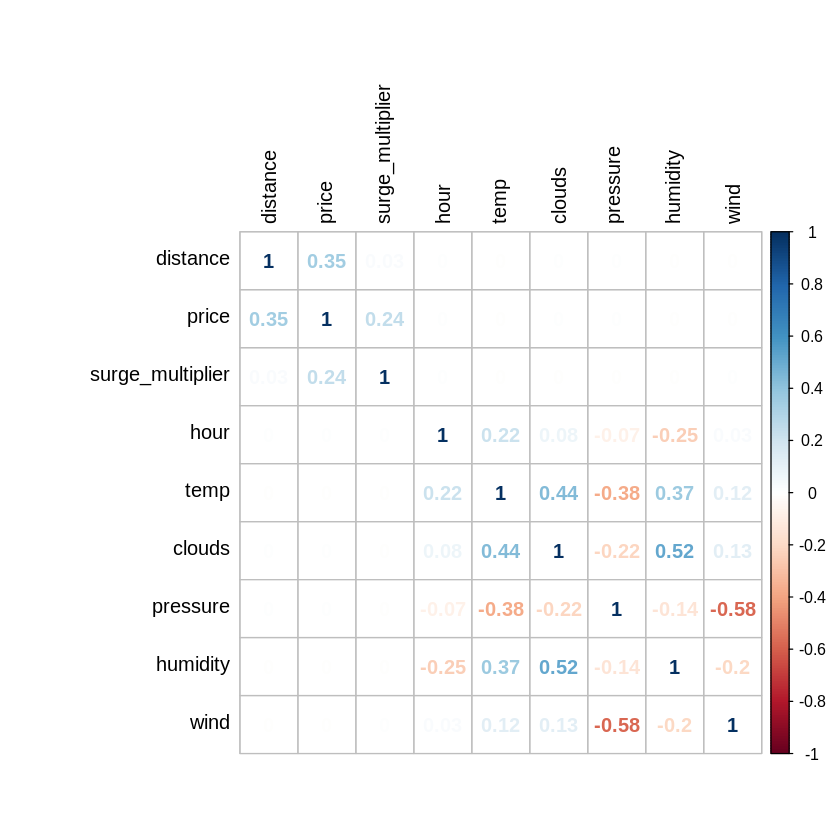

In [ ]:
# Test for collinearity
cor.matrix <- cor(numeric_col, method = 'pearson')
# Plot correlation matrix
corrplot(cor.matrix, method = 'number', tl.col = 'black')


Significant correlation betwen wind and pressure(-0.58), humidity and clouds(0.51)


**Hypothesis Testing**

Investigate if the cab type influences the price of a trip.

H0: Mean price of uber cabs = Mean price of lyft cabs

H1: Mean price of uber cabs ≠ Mean price of lyft cabs

In [ ]:
# Create sample of ride data for testing
sample_ride <- sample_n(ride_data, 200)

In [ ]:
# Test for normality of the data using the Shapiro-Wilk test
with(sample_ride, shapiro.test(price[cab_type == 'Uber']))


	Shapiro-Wilk normality test

data:  price[cab_type == "Uber"]
W = 0.86626, p-value = 1.967e-08


In [ ]:
with(sample_ride, shapiro.test(price[cab_type == 'Lyft']))


	Shapiro-Wilk normality test

data:  price[cab_type == "Lyft"]
W = 0.93068, p-value = 0.0001081


p-values are lesser than 0.05, data is not normally distributed therefore perform the wilcoxon rank test

In [ ]:
res <- wilcox.test(price ~ cab_type, data = sample_ride,
                   exact = FALSE)
res


	Wilcoxon rank sum test with continuity correction

data:  price by cab_type
W = 4272, p-value = 0.08786
alternative hypothesis: true location shift is not equal to 0


p-value is greater than 0.05, thus lack of significant evidence to reject the null hypothesis.

Investigate if there is significant difference in prices among different names per type

H0: Means of different groups are the same H1: At least one group sample mean is different from the others.

In [ ]:
# Create separate samples for both cab types
sample_uber <- sample_n(ride_data[ride_data$cab_type == 'Uber', ], 200)
sample_lyft <- sample_n(ride_data[ride_data$cab_type == 'Lyft', ], 200)

In [ ]:
# Compute the analysis of variance
uber.aov <- aov(price ~ name, data = sample_uber)
# Summary of the analysis
summary(uber.aov)

             Df Sum Sq Mean Sq F value Pr(>F)    
name          5  11815  2363.0   137.9 <2e-16 ***
Residuals   194   3325    17.1                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

p-value is less than the significance level 0.05, we can conclude that there are significant differences between the groups.


In [ ]:
# Compute the analysis of variance
lyft.aov <- aov(price ~ name, data = sample_lyft)
# Summary of the analysis
summary(lyft.aov)

             Df Sum Sq Mean Sq F value Pr(>F)    
name          5  15672  3134.4   78.99 <2e-16 ***
Residuals   194   7698    39.7                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

p-value is less than the significance level 0.05, we can conclude that there are significant differences between the groups.

In [ ]:
# Perform Tukey multiple pairwise comparison
TukeyHSD(uber.aov)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = price ~ name, data = sample_uber)

$name
                         diff         lwr        upr     p adj
Black SUV-Black     10.015476   6.8575408  13.173412 0.0000000
UberPool-Black     -12.189815 -15.5326461  -8.846984 0.0000000
UberX-Black        -10.565476 -13.6144843  -7.516468 0.0000000
UberXL-Black        -5.239035  -8.3458494  -2.132221 0.0000363
WAV-Black           -9.350490 -12.5272603  -6.173720 0.0000000
UberPool-Black SUV -22.205291 -25.2573773 -19.153205 0.0000000
UberX-Black SUV    -20.580952 -23.3080681 -17.853837 0.0000000
UberXL-Black SUV   -15.254511 -18.0461067 -12.462916 0.0000000
WAV-Black SUV      -19.365966 -22.2352134 -16.496719 0.0000000
UberX-UberPool       1.624339  -1.3149003   4.563578 0.6056655
UberXL-UberPool      6.950780   3.9516181   9.949941 0.0000000
WAV-UberPool         2.839325  -0.2322456   5.910895 0.0880751
UberXL-UberX         5.326441   2.6586893   7

Significant differences among uber cab types except 
- UberX-UberPool 
- WAV-UberPool
- WAV-UberX  

In [ ]:
TukeyHSD(lyft.aov)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = price ~ name, data = sample_lyft)

$name
                              diff        lwr         upr     p adj
Lux Black-Lux            5.8328042   1.188559  10.4770495 0.0050725
Lux Black XL-Lux        18.4214286  13.824239  23.0186184 0.0000000
Lyft-Lux                -6.9357143 -11.132355  -2.7390733 0.0000558
Lyft XL-Lux             -0.1344322  -4.356107   4.0872422 0.9999991
Shared-Lux             -10.3953917 -14.867294  -5.9234894 0.0000000
Lux Black XL-Lux Black  12.5886243   7.698097  17.4791512 0.0000000
Lyft-Lux Black         -12.7685185 -17.284589  -8.2524479 0.0000000
Lyft XL-Lux Black       -5.9672365 -10.506579  -1.4278936 0.0027894
Shared-Lux Black       -16.2281959 -21.001141 -11.4552505 0.0000000
Lyft-Lux Black XL      -25.3571429 -29.824808 -20.8894774 0.0000000
Lyft XL-Lux Black XL   -18.5558608 -23.047049 -14.0646723 0.0000000
Shared-Lux Black XL    -28.8168203 -33.543992 -2

Significant differences among all lyft cab types except

Lyft XL-Lux

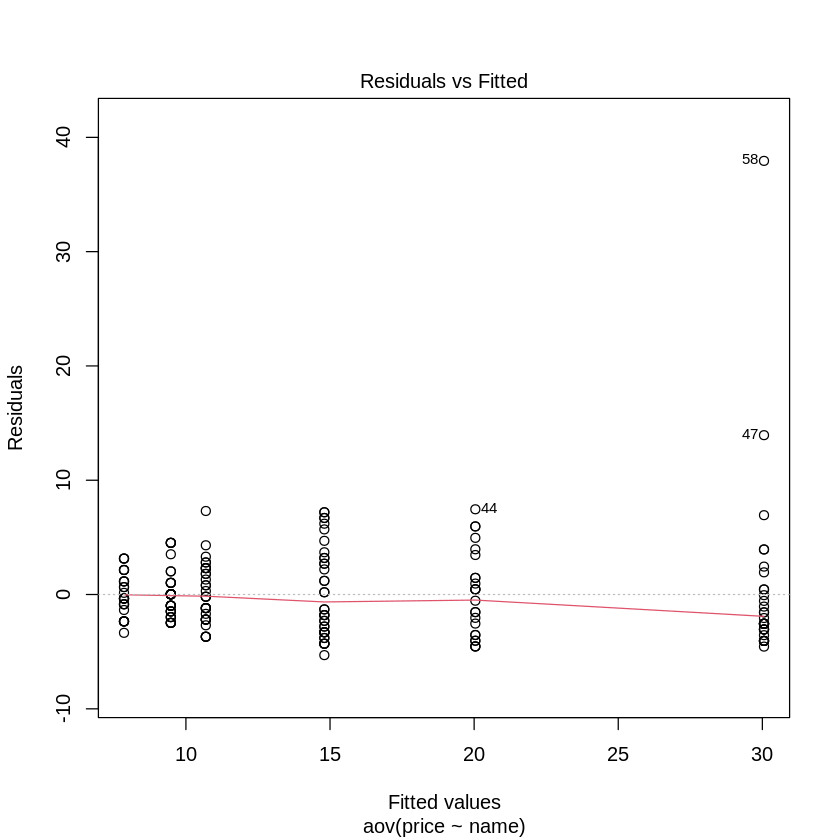

In [ ]:
# Check homogeneity of variance assumption
plot(uber.aov, 1)

There is no evident relationships between residuals and fitted values (the mean of each groups) thus homogeneity of variances can be assumed.

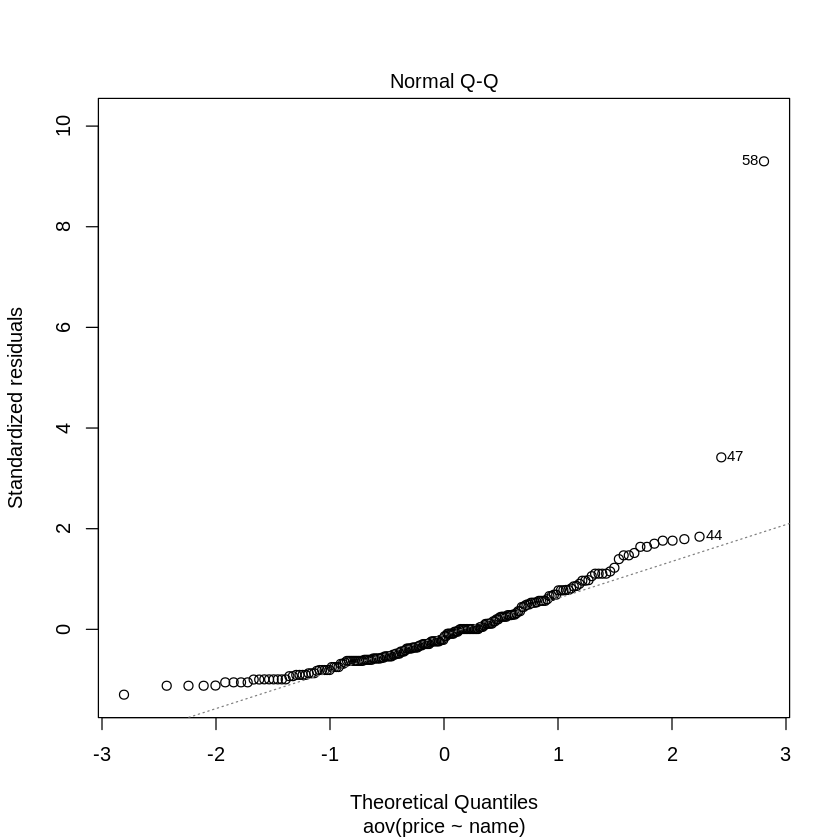

In [ ]:
plot(uber.aov,2)

In [ ]:
# Check for normality
residuals_uber <- residuals(object = uber.aov)
shapiro.test(x = residuals_uber)


	Shapiro-Wilk normality test

data:  residuals_uber
W = 0.71377, p-value < 2.2e-16


Violation of normality test, p-value less than 0.05


In [ ]:
# Perform krusak-wallis non-parametric test instead
kruskal.test(price ~ name, data = sample_uber)


	Kruskal-Wallis rank sum test

data:  price by name
Kruskal-Wallis chi-squared = 156.01, df = 5, p-value < 2.2e-16


p-value is less than 0.05 thus reject the null hypothesis test.

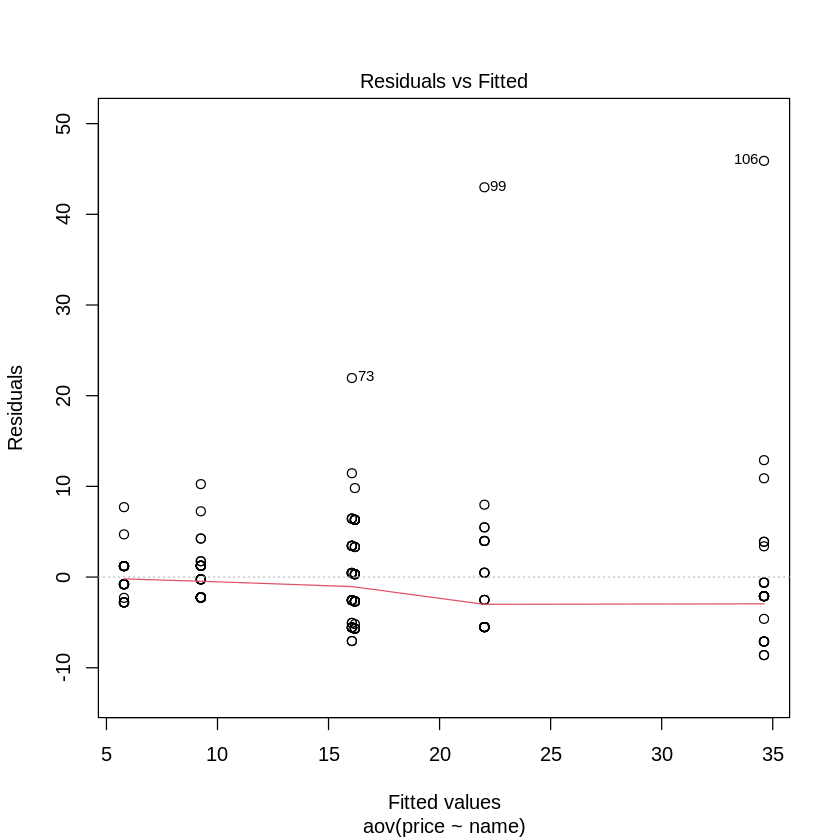

In [ ]:
# Check for homogeneity of variances
plot(lyft.aov, 1)

There is no evident relationships between residuals and fitted values (the mean of each groups) thus homogeneity of variances can be assumed.

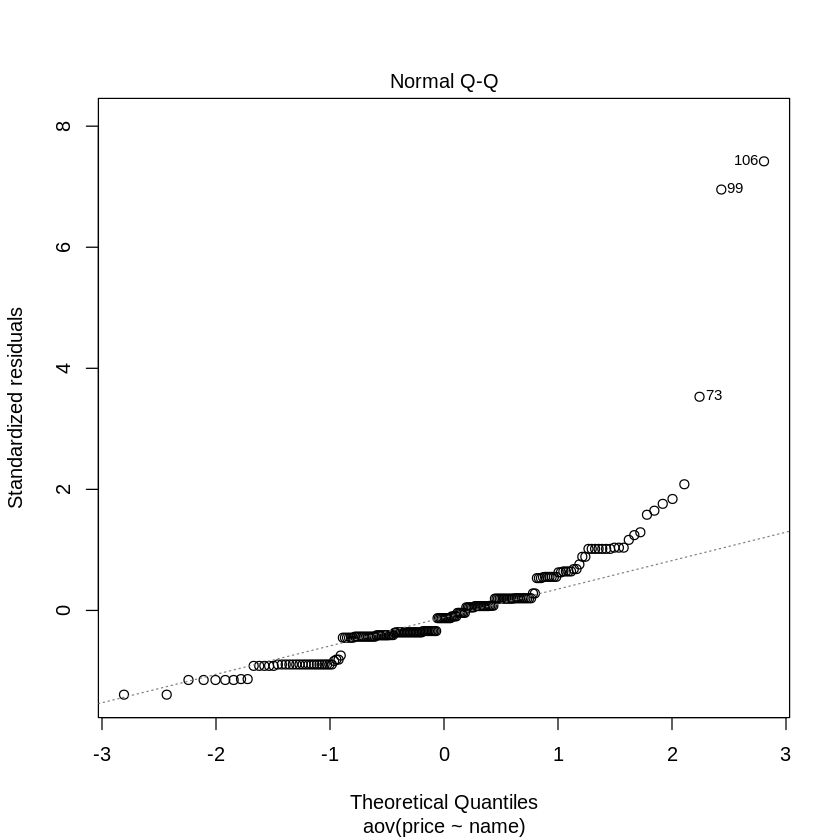

In [ ]:
# Check for normality
plot(lyft.aov, 2)

In [ ]:
residuals_lyft <- residuals(object = lyft.aov)
shapiro.test(residuals_lyft)


	Shapiro-Wilk normality test

data:  residuals_lyft
W = 0.68813, p-value < 2.2e-16


In [ ]:
# Normality check violated, perform krusak wallis test
kruskal.test(price ~ name, data = sample_lyft)


	Kruskal-Wallis rank sum test

data:  price by name
Kruskal-Wallis chi-squared = 157.89, df = 5, p-value < 2.2e-16


p-value less than 0.05, reject null hypothesis

**Data Modelling**

**Linear Regression**

In [ ]:
# Select columns to be used for modelling
model_data <- ride_data[, -c(3,4,5,8,10)]

model_data$cab_type <- as.factor(model_data$cab_type)
model_data$name <- as.factor(model_data$name)

In [ ]:
# One hot encode categorical features
ohe <- dummyVars(" ~ cab_type + name", data = model_data)
encoded_model <-  data.frame(predict(ohe, newdata = model_data))

encoded_model <- cbind(model_data[, -c(2,5)], encoded_model)
head(encoded_model)

,distance,price,surge_multiplier,hour,temp,clouds,pressure,humidity,wind,cab_type.Lyft,⋯,name.Lux,name.Lux.Black,name.Lux.Black.XL,name.Lyft,name.Lyft.XL,name.Shared,name.UberPool,name.UberX,name.UberXL,name.WAV
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.44,5.0,1,9,38.46000,0.2900000,1022.250,0.7600000,7.68000,1,⋯,0,0,0,0,0,1,0,0,0,0
2,0.44,11.0,1,2,44.06500,0.9950000,1002.880,0.8950000,12.63000,1,⋯,1,0,0,0,0,0,0,0,0,0
3,0.44,26.0,1,4,35.08000,0.0000000,1013.710,0.7000000,5.25000,1,⋯,0,0,1,0,0,0,0,0,0,0
4,0.44,9.0,1,3,37.68000,0.4333333,998.420,0.7066667,11.16000,1,⋯,0,0,0,0,1,0,0,0,0,0
5,0.44,16.5,1,18,40.78000,0.9300000,1000.150,0.7900000,7.55000,1,⋯,0,1,0,0,0,0,0,0,0,0
6,1.08,10.5,1,5,40.56125,0.9300000,1013.821,0.9212500,2.49625,1,⋯,0,0,0,0,1,0,0,0,0,0


In [ ]:
# scale data
encoded_model <- scale(encoded_model)
head(encoded_model)

,distance,price,surge_multiplier,hour,temp,clouds,pressure,humidity,wind,cab_type.Lyft,⋯,name.Lux,name.Lux.Black,name.Lux.Black.XL,name.Lyft,name.Lyft.XL,name.Shared,name.UberPool,name.UberX,name.UberXL,name.WAV
1,-1.5404170,-1.238187490,-0.1578861,-0.3795765,-0.1128523,-1.215909,0.8983978,0.09096848,0.2035581,1.036948,⋯,-0.295560,-0.2955191,-0.2955128,-0.2954782,-0.2955002,3.3844477,-0.3074534,-0.3074104,-0.3074748,-0.3074472
2,-1.5404170,-0.594643535,-0.1578861,-1.3873848,0.7357637,1.040862,-0.5497815,1.13828320,1.5615443,1.036948,⋯,3.383402,-0.2955191,-0.2955128,-0.2954782,-0.2955002,-0.2954687,-0.3074534,-0.3074104,-0.3074748,-0.3074472
3,-1.5404170,1.014216353,-0.1578861,-1.0994396,-0.6245957,-2.144227,0.2599129,-0.37450472,-0.4630897,1.036948,⋯,-0.295560,-0.2955191,3.3839428,-0.2954782,-0.2955002,-0.2954687,-0.3074534,-0.3074104,-0.3074748,-0.3074472
4,-1.5404170,-0.809158186,-0.1578861,-1.2434122,-0.2309469,-0.757086,-0.8832291,-0.32278548,1.1582636,1.036948,⋯,-0.295560,-0.2955191,-0.2955128,-0.2954782,3.3840870,-0.2954687,-0.3074534,-0.3074104,-0.3074748,-0.3074472
5,-1.5404170,-0.004728243,-0.1578861,0.9161772,0.2384036,0.832791,-0.7538873,0.32370509,0.1678938,1.036948,⋯,-0.295560,3.3838707,-0.2955128,-0.2954782,-0.2955002,-0.2954687,-0.3074534,-0.3074104,-0.3074748,-0.3074472
6,-0.9767023,-0.648272198,-0.1578861,-0.9554670,0.2052841,0.832791,0.2682304,1.34192773,-1.2185553,1.036948,⋯,-0.295560,-0.2955191,-0.2955128,-0.2954782,3.3840870,-0.2954687,-0.3074534,-0.3074104,-0.3074748,-0.3074472


In [ ]:
# Split data into test and train sets
set.seed(192020)
train_index <- createDataPartition(model_data$price, p = .7, list = FALSE)

In [ ]:
trainSet <- model_data[train_index,]
testSet <- model_data[-train_index,]

encodedTrain <- encoded_model[train_index,]
encodedTest <- encoded_model[-train_index,]

In [ ]:
# Perform linear regression with 5-fold cross validation
cv <- trainControl(method = 'cv', number = 5)
lm <- train(price ~ ., 
                       data = encodedTrain,
                       method = 'lm',
                       trControl = cv)
print(lm)

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”


Linear Regression 

444671 samples
    22 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 355737, 355738, 355735, 355737, 355737 
Resampling results:

  RMSE       Rsquared   MAE      
  0.2695146  0.9273785  0.1905714

Tuning parameter 'intercept' was held constant at a value of TRUE


In [ ]:
summary(lm)


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2323 -0.1578 -0.0211  0.1380  5.2983 

Coefficients: (3 not defined because of singularities)
                    Estimate Std. Error  t value Pr(>|t|)    
(Intercept)        1.321e-05  4.042e-04    0.033   0.9739    
distance           3.402e-01  4.045e-04  840.863   <2e-16 ***
surge_multiplier   1.878e-01  4.103e-04  457.675   <2e-16 ***
hour               1.424e-04  4.566e-04    0.312   0.7552    
temp               1.168e-03  5.034e-04    2.321   0.0203 *  
clouds            -9.047e-04  5.218e-04   -1.734   0.0829 .  
pressure           5.254e-04  5.489e-04    0.957   0.3384    
humidity           1.785e-04  5.750e-04    0.311   0.7562    
wind               1.234e-03  5.512e-04    2.239   0.0252 *  
cab_type.Lyft     -1.998e-01  9.892e-04 -202.010   <2e-16 ***
cab_type.Uber             NA         NA       NA       NA    
name.Black         3.242e-01  5.461e-04  593.606   <2e-16 **

In [ ]:
linear_predictions <- lm %>% predict(encodedTest)
 # Model prediction performance
data.frame(
  RMSE = RMSE(linear_predictions, encodedTest[,2]),
  Rsquare = R2(linear_predictions, encodedTest[,2])
)

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”


RMSE,Rsquare
<dbl>,<dbl>
0.2702955,0.9269044


The model perform quite well with an adjusted r-squared of 0.9274. However certain variables have their coefficients set to zero, due the presence of multicollinearity among some features, to counter this ridge regression.

**Ridge Regression**

In [ ]:
# Set up grid range of lambda values
 lambda <- 10^seq(-3, 3, length = 100)

In [ ]:
# Build the model
set.seed(123)
ridge <- train(
  price ~., data = encodedTrain, method = "glmnet",
  trControl = trainControl("cv", number = 5),
  tuneGrid = expand.grid(alpha = 0, lambda = lambda)
  )
arrange(ridge$results, RMSE) %>% head

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


,alpha,lambda,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0.001000000,0.2727521,0.9273599,0.1887029,0.002085494,0.0008411226,0.0007605834
2,0,0.001149757,0.2727521,0.9273599,0.1887029,0.002085494,0.0008411226,0.0007605834
3,0,0.001321941,0.2727521,0.9273599,0.1887029,0.002085494,0.0008411226,0.0007605834
4,0,0.001519911,0.2727521,0.9273599,0.1887029,0.002085494,0.0008411226,0.0007605834
5,0,0.001747528,0.2727521,0.9273599,0.1887029,0.002085494,0.0008411226,0.0007605834
6,0,0.002009233,0.2727521,0.9273599,0.1887029,0.002085494,0.0008411226,0.0007605834


Best performing model has an RMSE of 0.2696 and an R2 score off 0.927

**Lasso Regression**

In [ ]:
# Build the model
set.seed(123)
lasso <- train(
  price ~., data = encodedTrain, method = "glmnet",
  trControl = trainControl("cv", number = 5),
  tuneGrid = expand.grid(alpha = 1, lambda = lambda)
  )
arrange(lasso$results, RMSE) %>% head

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


,alpha,lambda,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.001000000,0.2696091,0.9273585,0.1897505,0.001977518,0.0008366031,0.0008238152
2,1,0.001149757,0.2696091,0.9273585,0.1897505,0.001977518,0.0008366031,0.0008238152
3,1,0.001321941,0.2696091,0.9273585,0.1897505,0.001977518,0.0008366031,0.0008238152
4,1,0.001519911,0.2696091,0.9273585,0.1897505,0.001977518,0.0008366031,0.0008238152
5,1,0.001747528,0.2696091,0.9273585,0.1897505,0.001977518,0.0008366031,0.0008238152
6,1,0.002009233,0.2696210,0.9273566,0.1896992,0.001978758,0.0008364843,0.0008231722


Best performing model has an RMSE of 0.2696 and an R2 score off 0.927

**Random Forest**

In [ ]:
random_forest <- train(price~.,
                      data = encodedTrain, 
                      method = 'treebag',
                      trControl = trainControl("cv", number = 5))

In [ ]:
random_forest

Bagged CART 

444671 samples
    22 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 355737, 355737, 355737, 355736, 355737 
Resampling results:

  RMSE       Rsquared   MAE      
  0.3883099  0.8492791  0.2728522


**Conclusion**

The most popular destination is the Financial District. Luxurious cabs have higher average prices compared to the shared cabs. The most popular hour for ride requests is between 11:00 pm and 12:00 midnight.
The most expensive hour to request for uber rides is at 9:00 am and 8:00 pm while for lyft is between 11:00 pm and 12:00 midnight.
The regression model has a higher R Squared score compared to the Random Forest Regressor.

There are different factors that affect pricing of a ride therefore the customer should look at these:

* Timing

* Distance

* Company Type (Lyft has generally higher prices than uber)

* Type of Car (The most expensive for Lyft is Black Lux Xl and for Uber is Black SUV and the cheapest are Uber Pool and Shared)
